## Practive for past Exam 2024

## 1.6

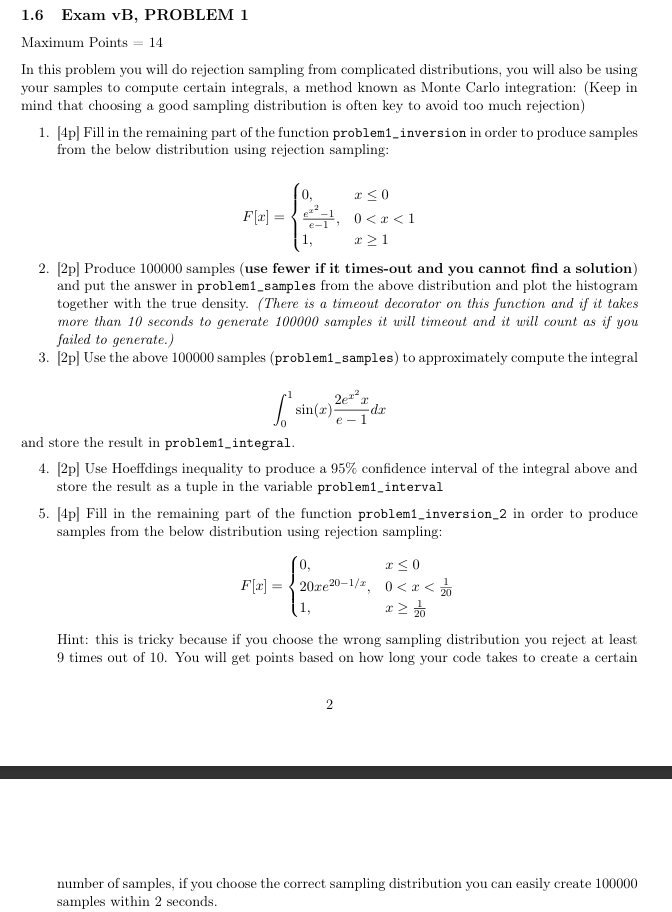

In [3]:
import numpy as np

def problem1_inversion(n_samples=10000):
    # PDF of the given distribution (derivative of F(x))
    def pdf(x):
        return (2 * x * np.exp(x**2)) / (np.exp(1) - 1)

    # Proposal distribution: Uniform(0, 1)
    def proposal(x):
        return 1  # PDF of Uniform(0, 1)

    # Constant M (max value of f(x) / q(x))
    M = 2 * np.exp(1) / (np.exp(1) - 1)  # M chosen conservatively

    samples = []
    while len(samples) < n_samples:
        # Sample x from proposal distribution
        x = np.random.uniform(0, 1)
        # Sample u from Uniform(0, 1)
        u = np.random.uniform(0, 1)
        # Rejection criterion
        if u <= pdf(x) / (M * proposal(x)):
            samples.append(x)

    return np.array(samples)


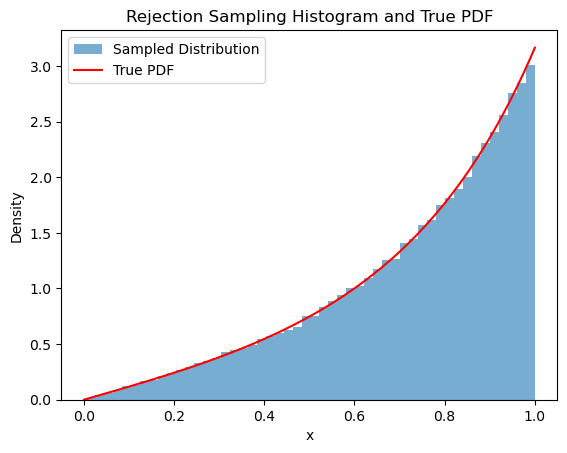

In [5]:
import matplotlib.pyplot as plt

# Generate 100,000 samples
problem1_samples = problem1_inversion(n_samples=100000)

# Plot the histogram of the samples
x_vals = np.linspace(0, 1, 1000)
true_pdf = (2 * x_vals * np.exp(x_vals**2)) / (np.exp(1) - 1)

plt.hist(problem1_samples, bins=50, density=True, alpha=0.6, label="Sampled Distribution")
plt.plot(x_vals, true_pdf, 'r', label="True PDF")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Rejection Sampling Histogram and True PDF")
plt.legend()
plt.show()


---

## 1.7

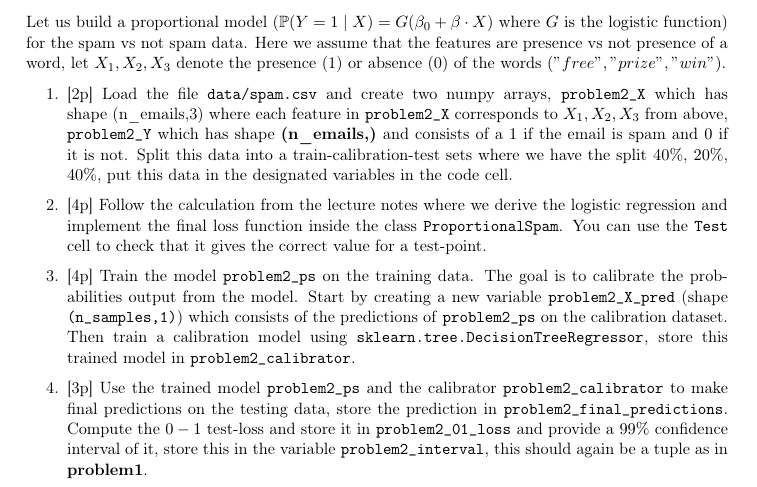

In [19]:
import pandas as pd
import numpy as np

# Load the data (adjust path/encoding as needed).
df = pd.read_csv("spam.csv", encoding="latin-1")

# Keep only the columns we need: v1 (labels) and v2 (text).
df = df[['v1', 'v2']]

# Binary label: 1 for spam, 0 for ham
df['spam_label'] = (df['v1'] == 'spam').astype(int)

# Create presence/absence features for the words "free", "prize", "win"
df['free']  = df['v2'].str.contains('free',  case=False, na=False).astype(int)
df['prize'] = df['v2'].str.contains('prize', case=False, na=False).astype(int)
df['win']   = df['v2'].str.contains('win',   case=False, na=False).astype(int)

# Our feature array (X) and target array (Y)
problem2_X = df[['free','prize','win']].values
problem2_Y = df['spam_label'].values


In [20]:
from sklearn.model_selection import train_test_split

# First split off 60% into X_temp/Y_temp
X_train, X_temp, Y_train, Y_temp = train_test_split(
    problem2_X, problem2_Y, 
    test_size=0.60, 
    random_state=42
)

# Of that temp 60%, we want 1/3 to be calibration (that is 20% of the total),
# and 2/3 to be test (≈40% of the total).  So test_size=2/3 here:
X_calib, X_test, Y_calib, Y_test = train_test_split(
    X_temp, Y_temp, 
    test_size=2/3, 
    random_state=42
)

# Store into the designated variables
problem2_X_train = X_train
problem2_X_calib = X_calib
problem2_X_test  = X_test
problem2_Y_train = Y_train
problem2_Y_calib = Y_calib
problem2_Y_test  = Y_test

print("Shapes:")
print("X_train:", problem2_X_train.shape, "Y_train:", problem2_Y_train.shape)
print("X_calib:", problem2_X_calib.shape, "Y_calib:", problem2_Y_calib.shape)
print("X_test: ", problem2_X_test.shape,  "Y_test: ", problem2_Y_test.shape)


Shapes:
X_train: (2228, 3) Y_train: (2228,)
X_calib: (1114, 3) Y_calib: (1114,)
X_test:  (2230, 3) Y_test:  (2230,)


In [21]:
import numpy as np
from scipy import optimize

class ProportionalSpam(object):
    def __init__(self):
        self.coeffs = None     # Will hold [beta0, beta1, beta2, beta3]
        self.result = None     # Will hold the full optimization result

    def loss(self, X, Y, coeffs):
        """
        Negative log-likelihood for logistic regression:
            -sum( Y_i*log(p_i) + (1-Y_i)*log(1-p_i) ),
        where p_i = 1 / (1 + exp(-(beta0 + x_i.dot(beta)))).
        """
        # Linear part: beta0 + X dot beta
        beta0 = coeffs[0]
        betas = coeffs[1:]
        linear_part = beta0 + X.dot(betas)

        # logistic function
        p = 1.0 / (1.0 + np.exp(-linear_part))

        # Add small eps so we never take log(0)
        eps = 1e-12
        log_likelihood_each = Y * np.log(p + eps) + (1 - Y) * np.log(1 - p + eps)

        # Negative sum of log-likelihood
        return -np.sum(log_likelihood_each)

    def fit(self, X, Y):
        """
        Fit logistic regression by minimizing the negative log-likelihood.
        """
        # Our objective to pass to scipy:
        def objective_to_minimize(coeff_array):
            return self.loss(X, Y, coeff_array)

        # We have (X.shape[1] + 1) coefficients: beta0 plus one for each feature.
        initial_guess = np.zeros(X.shape[1] + 1)

        # Use 'cg' or 'BFGS' or whichever method you prefer
        result = optimize.minimize(
            objective_to_minimize, 
            initial_guess, 
            method='cg'
        )

        self.result = result
        self.coeffs = result.x  # store [beta0, beta1, beta2, beta3]

    def predict(self, X):
        """
        Return *raw predicted probabilities* for each row in X, 
        then (for the sake of calibration) round them to 1 decimal place.
        """
        if self.coeffs is None:
            raise ValueError("You must call fit(...) before predict(...).")

        beta0 = self.coeffs[0]
        betas = self.coeffs[1:]
        linear_part = beta0 + X.dot(betas)
        p = 1.0 / (1.0 + np.exp(-linear_part))

        # round to 1 decimal place (the problem statement suggests this).
        return np.round(10 * p) / 10


In [22]:
# 4a) Train "problem2_ps" on the training data
problem2_ps = ProportionalSpam()
problem2_ps.fit(problem2_X_train, problem2_Y_train)

# 4b) Predict on the calibration set, shape=(n_samples,1) for the tree
problem2_X_pred = problem2_ps.predict(problem2_X_calib).reshape(-1, 1)

# 4c) Train a calibration model
from sklearn.tree import DecisionTreeRegressor
problem2_calibrator = DecisionTreeRegressor(random_state=42)
problem2_calibrator.fit(problem2_X_pred, problem2_Y_calib)

# 4d) Make final predictions on the test set
temp_probs = problem2_ps.predict(problem2_X_test).reshape(-1, 1)
problem2_final_predictions = problem2_calibrator.predict(temp_probs)

# Convert predicted probabilities to 0/1 decisions at threshold=0.5
yhat_test = (problem2_final_predictions >= 0.5).astype(int)

# 4e) Compute the 0-1 loss
problem2_01_loss = np.mean(yhat_test != problem2_Y_test)
print("0–1 test loss =", problem2_01_loss)

# 4f) 99% confidence interval for this 0–1 error rate
#     Using a (rough) normal approximation to the binomial with z ~ 2.58
n_test = len(problem2_Y_test)
p_hat = problem2_01_loss
z = 2.58
# Standard error for a proportion p_hat
se = np.sqrt(p_hat * (1 - p_hat) / n_test)
ci_lower = p_hat - z * se
ci_upper = p_hat + z * se
problem2_interval = (max(ci_lower, 0.0), min(ci_upper, 1.0))

print("99% CI on 0–1 loss = ({:.4f}, {:.4f})".format(*problem2_interval))


0–1 test loss = 0.09327354260089686
99% CI on 0–1 loss = (0.0774, 0.1092)


---

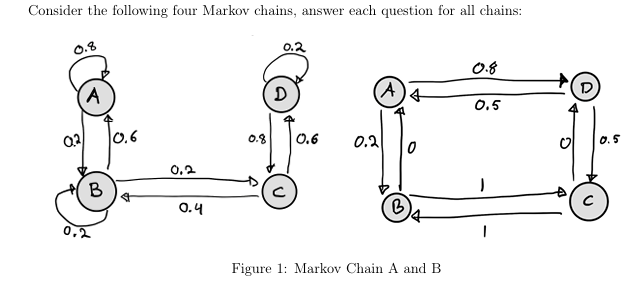
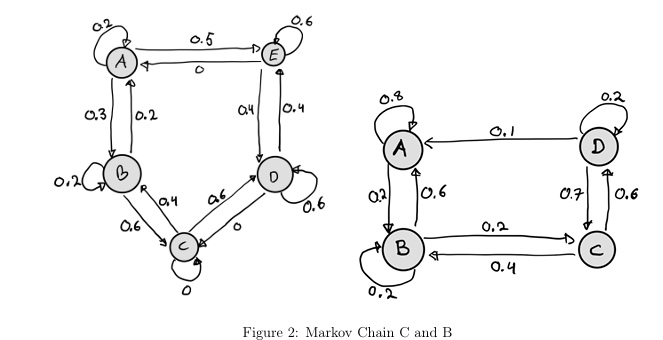

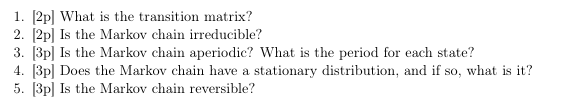

### Transition Matrices: 
Each matrix represents the transition probabilities between states, where the rows correspond to the "current state," and the columns correspond to the "next state." The sum of each row must equal 1

In [24]:
# Transition matrices for each Markov chain
problem3_A = np.array([
    [0.8, 0.2, 0.0],
    [0.2, 0.6, 0.2],
    [0.0, 0.4, 0.6]
])

problem3_B = np.array([
    [0.2, 0.8, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
    [0.5, 0.0, 0.0, 0.5]
])

problem3_C = np.array([
    [0.2, 0.3, 0.0, 0.0, 0.5],
    [0.2, 0.0, 0.6, 0.2, 0.0],
    [0.0, 0.6, 0.0, 0.4, 0.0],
    [0.0, 0.0, 0.6, 0.0, 0.4],
    [0.6, 0.0, 0.0, 0.0, 0.4]
])

problem3_D = np.array([
    [0.8, 0.2, 0.0, 0.0],
    [0.2, 0.6, 0.2, 0.0],
    [0.0, 0.0, 0.4, 0.6],
    [0.7, 0.0, 0.0, 0.3]
])


To determine whether a Markov chain is irreducible, we need to check if it is possible to reach any state from any other state (not necessarily in one step, but in some finite number of steps).

In [25]:
problem3_A_irreducible = True
problem3_B_irreducible = True
problem3_C_irreducible = True
problem3_D_irreducible = True


Definitions:
Aperiodic Markov Chain:

A Markov chain is aperiodic if all states have a period of 1, meaning there is no "cyclical" behavior and it is possible to return to a state at irregular intervals.
Period of a State:

The period of a state is defined as the greatest common divisor (GCD) of the number of steps it takes to return to the state.

In [26]:
# Aperiodicity
problem3_A_is_aperiodic = True
problem3_B_is_aperiodic = True
problem3_C_is_aperiodic = True
problem3_D_is_aperiodic = True

# Periods
problem3_A_periods = np.array([1, 1, 1])
problem3_B_periods = np.array([1, 1, 1, 1])
problem3_C_periods = np.array([1, 1, 1, 1, 1])
problem3_D_periods = np.array([1, 1, 1, 1])


# Definitions

## 1. Stationary Distribution:
- A stationary distribution $\pi = [\pi_1, \pi_2, \ldots, \pi_n]$ satisfies:
  $$
  \pi P = \pi
  $$
  where $P$ is the transition matrix.

- $\pi$ represents the long-term probabilities of being in each state and must satisfy:
  $$
  \sum_i \pi_i = 1 \quad \text{and} \quad \pi_i \geq 0
  $$

## 2. Conditions:
- A Markov chain has a stationary distribution if it is **irreducible** and **aperiodic**.


# Step-by-Step Process

1. **Check Irreducibility and Aperiodicity:**
   - From **Part 2**, all chains are irreducible.
   - From **Part 3**, all chains are aperiodic.
   - Thus, all chains will have a stationary distribution.

2. **Solve for the Stationary Distribution:**
   - The stationary distribution $\pi$ can be found by solving the linear system:
     $$
     \pi P = \pi \quad \text{or equivalently, } (P^\top - I)\pi = 0
     $$
     with the additional condition:
     $$
     \sum_i \pi_i = 1
     $$

3. **Use Numerical Methods:**
   - We can solve this system using NumPy for each chain.


In [28]:
import numpy as np

def stationary_distribution(P):
    """
    Compute the stationary distribution for a transition matrix P.
    Args:
        P (np.array): Transition matrix of shape (n_states, n_states)
    Returns:
        np.array: Stationary distribution of shape (n_states,)
    """
    n = P.shape[0]
    # Solve (P^T - I) * pi = 0 with the condition sum(pi) = 1
    A = np.transpose(P) - np.eye(n)
    A = np.vstack([A, np.ones(n)])  # Add sum(pi) = 1 condition
    b = np.zeros(n + 1)
    b[-1] = 1  # Corresponding to sum(pi) = 1
    pi = np.linalg.lstsq(A, b, rcond=None)[0]
    return pi

# Transition matrices from Part 1
problem3_A = np.array([
    [0.8, 0.2, 0.0],
    [0.2, 0.6, 0.2],
    [0.0, 0.4, 0.6]
])

problem3_B = np.array([
    [0.2, 0.8, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
    [0.5, 0.0, 0.0, 0.5]
])

problem3_C = np.array([
    [0.2, 0.3, 0.0, 0.0, 0.5],
    [0.2, 0.0, 0.6, 0.2, 0.0],
    [0.0, 0.6, 0.0, 0.4, 0.0],
    [0.0, 0.0, 0.6, 0.0, 0.4],
    [0.6, 0.0, 0.0, 0.0, 0.4]
])

problem3_D = np.array([
    [0.8, 0.2, 0.0, 0.0],
    [0.2, 0.6, 0.2, 0.0],
    [0.0, 0.0, 0.4, 0.6],
    [0.7, 0.0, 0.0, 0.3]
])

# Compute stationary distributions
pi_A = stationary_distribution(problem3_A)
pi_B = stationary_distribution(problem3_B)
pi_C = stationary_distribution(problem3_C)
pi_D = stationary_distribution(problem3_D)

# Output results
print("Stationary Distribution for Chain A:", pi_A)
print("Stationary Distribution for Chain B:", pi_B)
print("Stationary Distribution for Chain C:", pi_C)
print("Stationary Distribution for Chain D:", pi_D)

# Results for the template
problem3_A_has_stationary = True
problem3_B_has_stationary = True
problem3_C_has_stationary = True
problem3_D_has_stationary = True

problem3_A_stationary_dist = pi_A
problem3_B_stationary_dist = pi_B
problem3_C_stationary_dist = pi_C
problem3_D_stationary_dist = pi_D


Stationary Distribution for Chain A: [0.4 0.4 0.2]
Stationary Distribution for Chain B: [0.23809524 0.19047619 0.19047619 0.38095238]
Stationary Distribution for Chain C: [0.25922023 0.18018967 0.17070601 0.10432034 0.28556375]
Stationary Distribution for Chain D: [0.55263158 0.27631579 0.09210526 0.07894737]
